In [1]:
%load_ext autoreload
%autoreload 3

import modules.constants as const
import modules.measures as measures
import modules.plotting as plotting
import modules.constants as const
import modules.data_preparation as data_prep
import modules.statistics as stat

from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd
import pickle

In [2]:
ADAPT_TO_MIO_OBJECTIVES = True

In [3]:
sns.set_theme(style="darkgrid")
boxplot_output_path = Path(const.DIAGRAM_OUT_PATH)

In [4]:
x = "Fitness function"
measure_name = "Neutrality distance"
y = measure_name

df = pd.read_csv("store2/neutrality_distance_measure_df_with_objectives.csv")

if ADAPT_TO_MIO_OBJECTIVES:
    df = pd.merge(df, data_prep.get_mio_runs()[const.OBJECTIVE].drop_duplicates(), on=const.OBJECTIVE)

df

,Fitness function,Objective,Neutrality distance
0,Branch distance,de.arnowelzel.android.periodical0,45
1,Branch distance,de.arnowelzel.android.periodical0,3
2,Branch distance,de.arnowelzel.android.periodical0,5
3,Branch distance,de.arnowelzel.android.periodical0,3
4,Branch distance,de.arnowelzel.android.periodical0,82
...,...,...,...
51995,Code-based fitness,de.drhoffmannsoftware347,25
51996,Code-based fitness,de.drhoffmannsoftware347,15
51997,Code-based fitness,de.drhoffmannsoftware347,1
51998,Code-based fitness,de.drhoffmannsoftware347,13


In [5]:
data_points_rq1 = len(df.index)

# Results RQ1

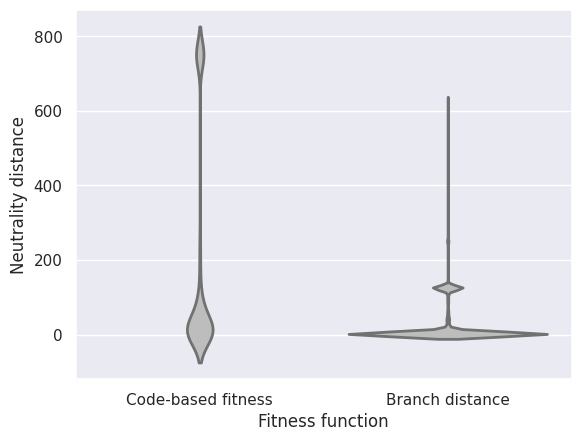

In [6]:
output_file = boxplot_output_path / (measure_name + ".pdf")
output_file2 = boxplot_output_path / (measure_name + "2.pdf")

fig = plt.figure()
ax = sns.violinplot(data=df, x=x, y=y, linewidth=2, color="#bdbdbd", order=[const.CODE_BASED, const.BRANCH_DISTANCE], inner=None)
plt.savefig(output_file)
plt.close(fig)
fig

For visual clarity, the kernel density plots and box plots were drawn separately for neutrality distance.

In [7]:
branch_fitness_df = df[df[const.FITNESS_FUNCTION] == const.CODE_BASED]
branch_distance_df = df[df[const.FITNESS_FUNCTION] == const.BRANCH_DISTANCE]
assert(df.size == branch_fitness_df.size + branch_distance_df.size)

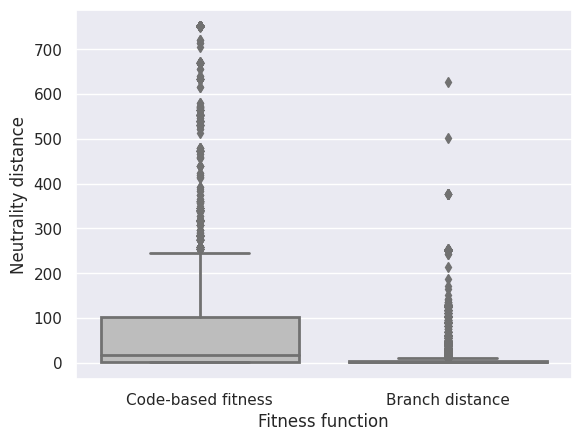

In [8]:
fig = plt.figure()
sns.boxplot(data=df, x=x, y=y, linewidth=2, color="#bdbdbd", order=[const.CODE_BASED, const.BRANCH_DISTANCE])
plt.savefig(output_file2)
plt.close(fig)
fig

# Discussion RQ1

As can be seen in the histogram, for the  code-based fitness function, many random walks resulted in a completely flat landscape, which never happened for the branch distance function.

# RQ2

First, we create a dictionary of the form <app_name><objective> -> <fitness_function> -> list of neutrality distances
The values in the lists of this dictionary should be all the values of the previous RQ

In [9]:
for index, row in df.groupby([const.FITNESS_FUNCTION, const.OBJECTIVE]).aggregate(lambda l: len(l)).iterrows():
    assert row[const.NEUTRALITY_DISTANCE] == 20

Now, we create a dictionary of the form <app_name><objective> -> (p_value, effect_size).
We should have as many p_values and effect_sizes as values in the old dict.

In [10]:
objectives = df['Objective'].drop_duplicates()
fitness_functions = [const.CODE_BASED, const.BRANCH_DISTANCE]

neutrality_distance_dict_ps = {}

for objective in objectives:
    branch_distance_list = df[(df[const.FITNESS_FUNCTION] == const.BRANCH_DISTANCE) & (df[const.OBJECTIVE] == objective)][const.NEUTRALITY_DISTANCE]
    code_based_list = df[(df[const.FITNESS_FUNCTION] == const.CODE_BASED) & (df[const.OBJECTIVE] == objective)][const.NEUTRALITY_DISTANCE]
    assert len(branch_distance_list) == 20
    assert len(code_based_list) == 20
    neutrality_distance_dict_ps[objective] = stat.calculate_mann_whitney_p_value(list(code_based_list), list(branch_distance_list))

As we can see, we have no none values and a p value and effect size for every objective

In [11]:
print(len(list(neutrality_distance_dict_ps.keys())))

statistics_tuples = list(neutrality_distance_dict_ps.values())
p_values_not_none = [x[0] for x in statistics_tuples if x[0] is not None]

if ADAPT_TO_MIO_OBJECTIVES:
    assert len(p_values_not_none) == 1300
else:
    assert len(p_values_not_none) == 2607

print("p_values not none: " + str(len(p_values_not_none)))
print("of all: " + str(len(statistics_tuples)))

1300
p_values not none: 1300
of all: 1300


No None values in p-values!

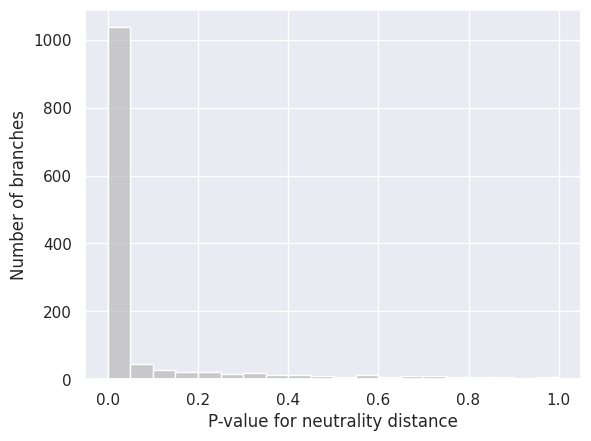

In [12]:
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import modules.constants as const
from pathlib import Path
import seaborn as sns

output_file = Path(const.DIAGRAM_OUT_PATH) / "neutrality_distance_p-values.pdf"

sns.set_theme(style="darkgrid")

fig = plt.figure()
sns.histplot(p_values_not_none, binwidth=0.05, color="#bdbdbd")
plt.xlabel("P-value for neutrality distance")
plt.ylabel("Number of branches")

plt.savefig(output_file)
plt.close(fig)

fig

significant: 1037
insignificant: 263


<Figure size 640x480 with 0 Axes>

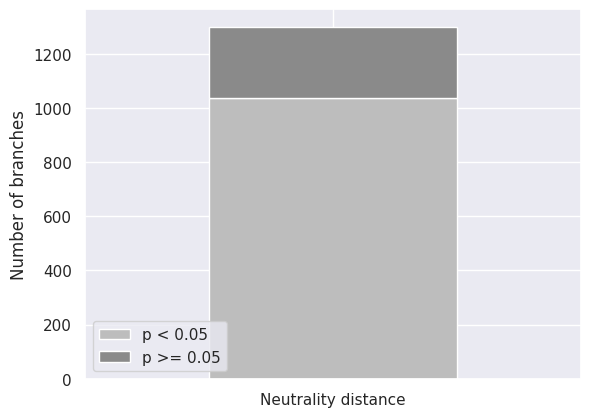

In [13]:
p_values_significant = [x for x in p_values_not_none if x < 0.05]
p_values_insignificant = [x for x in p_values_not_none if x >= 0.05]

assert len(p_values_not_none) == len(p_values_significant) + len(p_values_insignificant)

fig = plt.figure()

number_significant = len(p_values_significant)
number_insignificant = len(p_values_insignificant)

barplot_data_dict = {"p < 0.05": [number_significant], "p >= 0.05": [number_insignificant]}
barplot_data_df = pd.DataFrame(barplot_data_dict, index=[const.NEUTRALITY_DISTANCE])

# sns.barplot(data=barplot_data_df, color="#bdbdbd")

ax = barplot_data_df.plot(kind='bar', stacked=True, color=["#bdbdbd", '#8a8a8a', 'green'])
sns.move_legend(ax, "lower left")
plt.ylabel("Number of branches")
plt.xticks(rotation=0)

plt.savefig(Path(const.DIAGRAM_OUT_PATH) / "neutrality_distance_p-values_two-bins.pdf")
plt.close(fig)

print("significant: " + str(len(p_values_significant)))
print("insignificant: " + str(len(p_values_insignificant)))

fig

In [14]:
effect_size_values = [x[1] for x in statistics_tuples if x[0] is not None]
effect_size_values_not_none = [x for x in effect_size_values if x is not None]
print("not none: " + str(len(effect_size_values_not_none)))
print("of all: " + str(len(effect_size_values)))
print("for #p_values: " + str(len(p_values_not_none)))

not none: 1300
of all: 1300
for #p_values: 1300


For every p-value, we have an effect size value!

In [15]:
effect_size_values_not_none_significant = [x[1] for x in statistics_tuples if x[0] is not None and x[0] < 0.05 and x[1] is not None]
effect_size_values_not_none_insignificant = [x[1] for x in statistics_tuples if x[0] is not None and x[0] >= 0.05 and x[1] is not None]
assert len(effect_size_values_not_none) == len(effect_size_values_not_none_significant) + len(effect_size_values_not_none_insignificant)

we divided the effect sizes up into a significant and insignificant portion.

Now we want to make a violin plot for the significant ones:

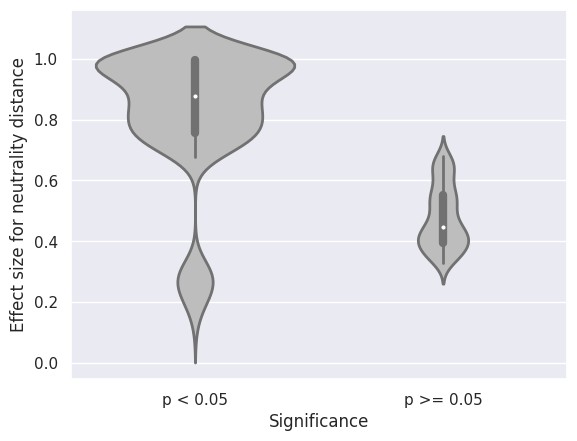

In [16]:
sns.set_theme(style="darkgrid")

x_axis = "Significance"
y_axis = "Effect size for neutrality distance"

list_of_tuples = []
for size in effect_size_values_not_none_significant:
    list_of_tuples.append(("p < 0.05", size))
for size in effect_size_values_not_none_insignificant:
    list_of_tuples.append(("p >= 0.05", size))

effect_sizes_df = pd.DataFrame(list_of_tuples, columns=[x_axis, y_axis])

fig = plt.figure()
sns.violinplot(data=effect_sizes_df, x=x_axis, y=y_axis, linewidth=2, color="#bdbdbd", order=["p < 0.05", "p >= 0.05"], scale="count")
plt.savefig(Path(const.DIAGRAM_OUT_PATH) / "neutrality_distance_effect_size.pdf")
plt.close(fig)
fig

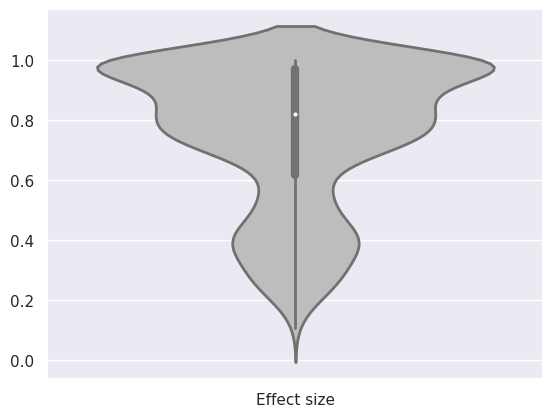

In [17]:
sns.set_theme(style="darkgrid")

effect_size_values_not_none_df = pd.DataFrame(effect_size_values_not_none, columns=["Effect size"])

fig = plt.figure()
sns.violinplot(data=effect_size_values_not_none_df, linewidth=2, color="#bdbdbd")
plt.savefig(Path(const.DIAGRAM_OUT_PATH) / "neutrality_distance_effect-size_aggregated.pdf")
plt.close(fig)
fig